In [2]:
# import libraries
import pandas as pd

In [3]:
# create dataframe
df = pd.read_csv("dataset.csv")
df = df.drop(["AVERAGE"], axis=1)
df

,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.60,11.1,8.5,25.0,25,Cosmetic
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.20,20.0,10.0,6.0,15,European-style renovation
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.70,16.2,13.1,10.0,25,Cosmetic
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.10,16.0,11.0,12.0,33,European-style renovation
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.70,15.2,4.0,5.0,5,Without renovation
...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,New building,Котельники,8.0,Moscow region,0.0,31.75,13.0,5.0,4.0,17,Cosmetic
22672,5900000.0,New building,Домодедовская,25.0,Moscow region,1.0,31.60,10.1,12.2,11.0,15,Cosmetic
22673,3700000.0,New building,Котельники,30.0,Moscow region,0.0,18.00,15.0,8.1,17.0,17,Cosmetic
22674,5768869.0,New building,Жулебино,14.0,Moscow region,2.0,36.39,22.0,6.6,12.0,14,Cosmetic


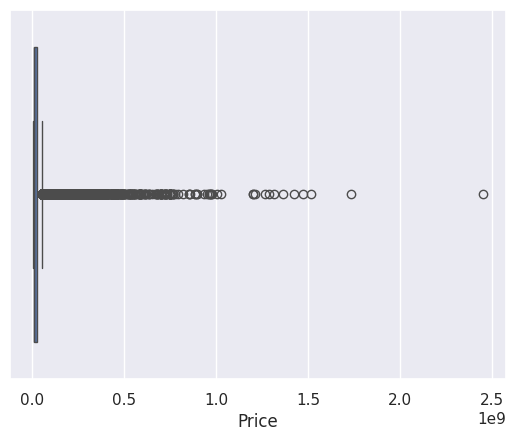

In [4]:
import seaborn as sns

sns.set_theme()

sns.boxplot(data=df, x="Price")
df = df[df["Price"] < 1e9]

In [5]:
def remove_outliers(df, column, quant=0.03):
    return df[
        (df[column] > df[column].quantile(quant))
        & (df[column] < df[column].quantile(1 - quant))
    ]

<Axes: xlabel='Price', ylabel='Count'>

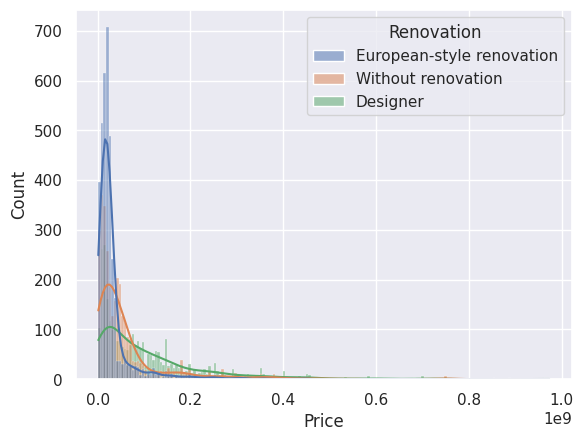

In [6]:
sns.histplot(
    data=remove_outliers(df[df["Renovation"] != "Cosmetic"], "Price", quant=0),
    x="Price",
    hue="Renovation",
    kde=True,
)

<Axes: xlabel='Price', ylabel='Count'>

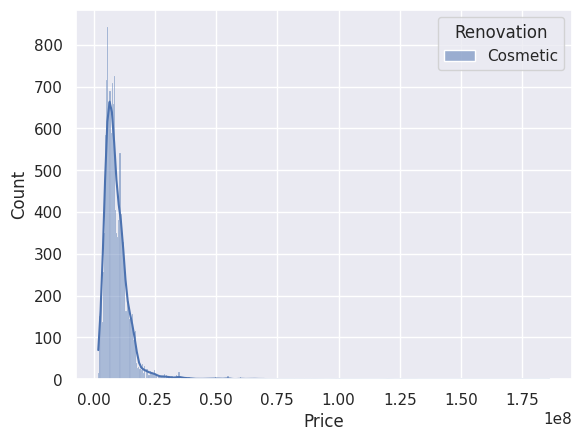

In [7]:
# plot pricing having removed outliers
sns.histplot(
    data=remove_outliers(df[df["Renovation"] == "Cosmetic"], "Price", quant=0),
    x="Price",
    hue="Renovation",
    kde=True,
)

<Axes: xlabel='Price'>

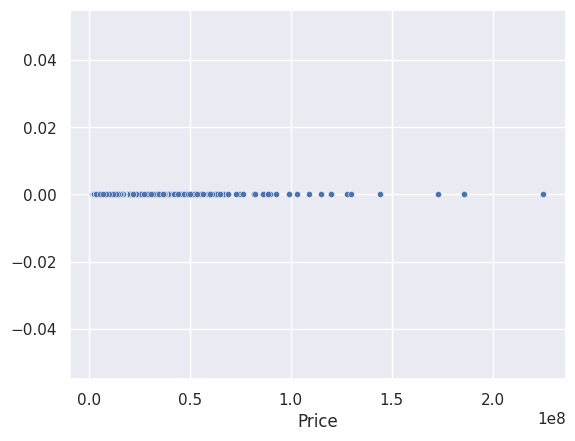

In [8]:
# check if "Renovation"=="Cosmetic" has outliers
sns.scatterplot(data=df[df["Renovation"] == "Cosmetic"], x="Price", y=0, s=20)

<Axes: xlabel='Area', ylabel='Price'>

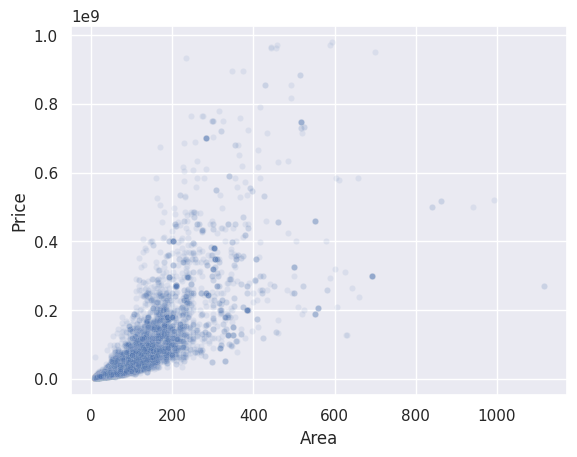

In [9]:
sns.scatterplot(
    data=df[df["Apartment type"] == "Secondary"], x="Area", y="Price", alpha=0.1, s=20
)

<Axes: xlabel='Area', ylabel='Price'>

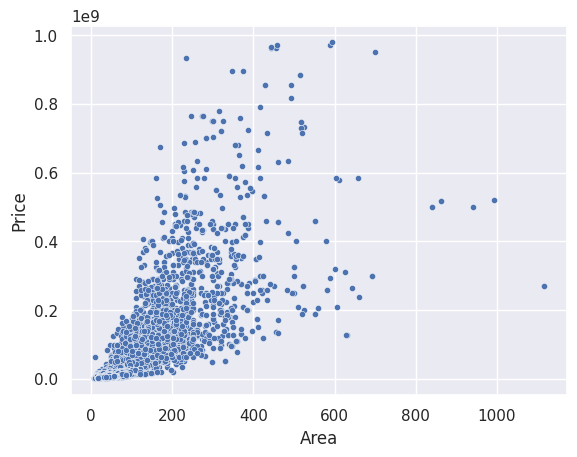

In [10]:
sns.scatterplot(data=df, x="Area", y="Price", s=20)

<Axes: xlabel='Number of rooms', ylabel='Price'>

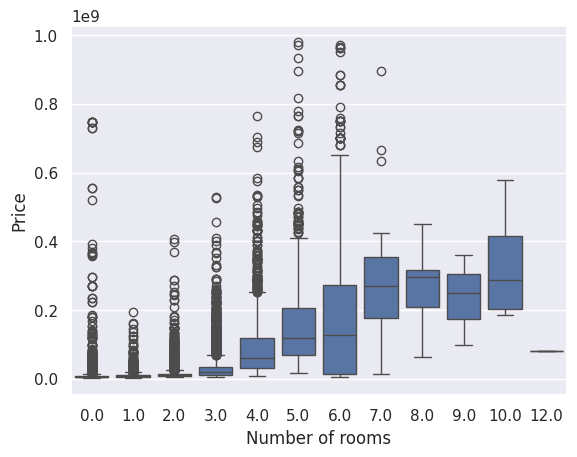

In [11]:
sns.boxplot(data=df, x="Number of rooms", y="Price")

In [12]:
%pip install category_encoders scikit-learn

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /home/kitlix/.pyenv/versions/3.11.2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [13]:
theatric_df = pd.read_csv("theatric.csv")
# map station name to time
time_to_teatralnaya = dict()
for row in theatric_df.itertuples():
    rowdata = row[1]
    row_time = int(rowdata.split(" ")[-1])
    row_name = " ".join(rowdata.split(" ")[:-1])
    time_to_teatralnaya[row_name] = row_time
time_to_teatralnaya

{'Опалиха': 59,
 'Павшино': 52,
 'Мякинино': 41,
 'Строгино': 37,
 'Нахабино': 65,
 'Красногорская': 55,
 'Тушинская': 34,
 'Аникеевка': 61,
 'Волоколамская': 44,
 'Пенягино': 49,
 'Митино': 46,
 'Пятницкое шоссе': 48,
 'Чеховская': 7,
 'Арбатская': 11,
 'Фили': 29,
 'Белорусская': 10,
 'Кропоткинская': 9,
 'Спортивная': 16,
 'Алексеевская': 22,
 'Ростокино': 40,
 'Китай-город': 11,
 'ВДНХ': 24,
 'Динамо': 10,
 'Филатов Луг': 41,
 'Раменки': 31,
 'Минская': 27,
 'Аминьевская': 38,
 'Давыдково': 39,
 'Фрунзенская': 14,
 'Улица 1905 года': 12,
 'Кунцевская': 27,
 'Шелепиха': 30,
 'Молодёжная': 27,
 'Беговая': 19,
 'Бауманская': 12,
 'Славянский бульвар': 23,
 'Новокузнецкая': 4,
 'Парк Культуры': 14,
 'Смоленская': 13,
 'Пушкинская': 6,
 'Комсомольская': 16,
 'Серпуховская': 15,
 'Трубная': 14,
 'Народное Ополчение': 27,
 'Киевская': 16,
 'Технопарк': 13,
 'Преображенская площадь': 21,
 'Павелецкая': 8,
 'Красные ворота': 11,
 'Тверская': 3,
 'Петровский Парк': 16,
 'Аэропорт': 13,
 'Пло

In [14]:
df["Time to Teatralnaya"] = df["Metro station"].map(time_to_teatralnaya)
df

/tmp/ipykernel_263555/1741767373.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Time to Teatralnaya"] = df["Metro station"].map(time_to_teatralnaya)


,Price,Apartment type,Metro station,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation,Time to Teatralnaya
0,6300000.0,Secondary,Опалиха,6.0,Moscow region,1.0,30.60,11.1,8.5,25.0,25,Cosmetic,59
1,9000000.0,Secondary,Павшино,2.0,Moscow region,1.0,49.20,20.0,10.0,6.0,15,European-style renovation,52
2,11090000.0,Secondary,Мякинино,14.0,Moscow region,1.0,44.70,16.2,13.1,10.0,25,Cosmetic,41
3,8300000.0,Secondary,Строгино,8.0,Moscow region,1.0,35.10,16.0,11.0,12.0,33,European-style renovation,37
4,6450000.0,Secondary,Опалиха,6.0,Moscow region,1.0,37.70,15.2,4.0,5.0,5,Without renovation,59
...,...,...,...,...,...,...,...,...,...,...,...,...,...
22671,4768792.0,New building,Котельники,8.0,Moscow region,0.0,31.75,13.0,5.0,4.0,17,Cosmetic,42
22672,5900000.0,New building,Домодедовская,25.0,Moscow region,1.0,31.60,10.1,12.2,11.0,15,Cosmetic,31
22673,3700000.0,New building,Котельники,30.0,Moscow region,0.0,18.00,15.0,8.1,17.0,17,Cosmetic,42
22674,5768869.0,New building,Жулебино,14.0,Moscow region,2.0,36.39,22.0,6.6,12.0,14,Cosmetic,40


In [15]:
X = df.drop(["Price", "Metro station"], axis=1)
y = df["Price"]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [17]:
X_train

,Apartment type,Minutes to metro,Region,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation,Time to Teatralnaya
1048,Secondary,7.0,Moscow region,1.0,41.8,23.3,10.1,5.0,6,Cosmetic,59
9168,Secondary,7.0,Moscow,3.0,63.0,45.0,6.5,12.0,12,Without renovation,26
6486,Secondary,13.0,Moscow,2.0,46.0,30.0,7.0,4.0,12,Cosmetic,39
8962,Secondary,14.0,Moscow,3.0,70.3,47.0,7.8,2.0,15,Without renovation,13
10051,Secondary,10.0,Moscow,4.0,200.2,103.3,23.2,4.0,7,Cosmetic,13
...,...,...,...,...,...,...,...,...,...,...,...
11977,Secondary,10.0,Moscow,0.0,12.0,8.2,7.6,1.0,12,Cosmetic,30
21589,New building,6.0,Moscow,4.0,108.6,57.0,15.6,3.0,10,European-style renovation,20
5396,Secondary,0.0,Moscow,1.0,41.0,13.0,20.0,8.0,21,Designer,13
860,Secondary,5.0,Moscow,6.0,207.0,150.0,20.0,2.0,5,European-style renovation,10


In [18]:
import category_encoders as ce

encoder = ce.OneHotEncoder(cols=["Apartment type", "Region", "Renovation"])
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)
X_train

,Apartment type_1,Apartment type_2,Minutes to metro,Region_1,Region_2,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation_1,Renovation_2,Renovation_3,Renovation_4,Time to Teatralnaya
1048,1,0,7.0,1,0,1.0,41.8,23.3,10.1,5.0,6,1,0,0,0,59
9168,1,0,7.0,0,1,3.0,63.0,45.0,6.5,12.0,12,0,1,0,0,26
6486,1,0,13.0,0,1,2.0,46.0,30.0,7.0,4.0,12,1,0,0,0,39
8962,1,0,14.0,0,1,3.0,70.3,47.0,7.8,2.0,15,0,1,0,0,13
10051,1,0,10.0,0,1,4.0,200.2,103.3,23.2,4.0,7,1,0,0,0,13
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11977,1,0,10.0,0,1,0.0,12.0,8.2,7.6,1.0,12,1,0,0,0,30
21589,0,1,6.0,0,1,4.0,108.6,57.0,15.6,3.0,10,0,0,1,0,20
5396,1,0,0.0,0,1,1.0,41.0,13.0,20.0,8.0,21,0,0,0,1,13
860,1,0,5.0,0,1,6.0,207.0,150.0,20.0,2.0,5,0,0,1,0,10


In [19]:
from sklearn.preprocessing import RobustScaler

cols = X_train.columns
scaler = RobustScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
X_train = pd.DataFrame(X_train, columns=[cols])
X_test = pd.DataFrame(X_test, columns=[cols])
X_train

,Apartment type_1,Apartment type_2,Minutes to metro,Region_1,Region_2,Number of rooms,Area,Living area,Kitchen area,Floor,Number of floors,Renovation_1,Renovation_2,Renovation_3,Renovation_4,Time to Teatralnaya
0,0.0,0.0,-0.500,1.0,-1.0,-0.5,-0.287661,-0.203922,-0.084746,-0.333333,-1.111111,0.0,0.0,0.0,0.0,2.000000
1,0.0,0.0,-0.500,0.0,0.0,0.5,0.247287,0.647059,-0.694915,0.444444,-0.444444,-1.0,1.0,0.0,0.0,-0.538462
2,0.0,0.0,0.250,0.0,0.0,0.0,-0.181681,0.058824,-0.610169,-0.444444,-0.444444,0.0,0.0,0.0,0.0,0.461538
3,0.0,0.0,0.375,0.0,0.0,0.5,0.431491,0.725490,-0.474576,-0.666667,-0.111111,-1.0,1.0,0.0,0.0,-1.538462
4,0.0,0.0,-0.125,0.0,0.0,1.0,3.709311,2.933333,2.135593,-0.444444,-1.000000,0.0,0.0,0.0,0.0,-1.538462
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18124,0.0,0.0,-0.125,0.0,0.0,-1.0,-1.039616,-0.796078,-0.508475,-0.777778,-0.444444,0.0,0.0,0.0,0.0,-0.230769
18125,-1.0,1.0,-0.625,0.0,0.0,1.0,1.397931,1.117647,0.847458,-0.555556,-0.666667,-1.0,0.0,1.0,0.0,-1.000000
18126,0.0,0.0,-1.375,0.0,0.0,-0.5,-0.307848,-0.607843,1.593220,0.000000,0.555556,-1.0,0.0,0.0,1.0,-1.538462
18127,0.0,0.0,-0.750,0.0,0.0,2.0,3.880898,4.764706,1.593220,-0.666667,-1.222222,-1.0,0.0,1.0,0.0,-1.769231


In [20]:
%pip install catboost

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /home/kitlix/.pyenv/versions/3.11.2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [21]:
%pip install ipywidgets ipython

DEPRECATION: torchsde 0.2.5 has a non-standard dependency specifier numpy>=1.19.*; python_version >= "3.7". pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of torchsde or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: /home/kitlix/.pyenv/versions/3.11.2/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [32]:
from catboost import Pool

X_eval = X_test
y_eval = y_test

eval_dataset = Pool(data=X_eval, label=y_eval)

In [43]:
from catboost import CatBoostRegressor

model = CatBoostRegressor(task_type="GPU", iterations=25000, devices="0:1")
model.fit(X_train, y_train, eval_set=eval_dataset)
y_pred = model.predict(X_test)
model.save_model("model.cbm")


Learning rate set to 0.033932
0:	learn: 72922634.1328549	test: 75382688.3099044	best: 75382688.3099044 (0)	total: 13.8ms	remaining: 5m 44s
1:	learn: 71223066.0512732	test: 73674214.6194590	best: 73674214.6194590 (1)	total: 25ms	remaining: 5m 12s
2:	learn: 69606100.5820961	test: 72026593.0307701	best: 72026593.0307701 (2)	total: 36.7ms	remaining: 5m 5s
3:	learn: 68090558.2793870	test: 70479054.5441456	best: 70479054.5441456 (3)	total: 48.3ms	remaining: 5m 1s
4:	learn: 66633793.4028456	test: 69008192.5335961	best: 69008192.5335961 (4)	total: 59.4ms	remaining: 4m 56s
5:	learn: 65200259.1011712	test: 67623534.0302568	best: 67623534.0302568 (5)	total: 70.5ms	remaining: 4m 53s
6:	learn: 63861180.5338200	test: 66272356.7714808	best: 66272356.7714808 (6)	total: 82.6ms	remaining: 4m 54s
7:	learn: 62580000.9196605	test: 65043093.1308229	best: 65043093.1308229 (7)	total: 94ms	remaining: 4m 53s
8:	learn: 61329928.0754587	test: 63816460.3953560	best: 63816460.3953560 (8)	total: 105ms	remaining: 4m 

In [44]:
from sklearn.metrics import mean_absolute_percentage_error

mean_absolute_percentage_error(y_test, y_pred)

0.1818920661734443

In [46]:
model.fit(X_train, y_train, eval_set=eval_dataset, init_model="model.cbm")
y_pred = model.predict(X_test)
model.save_model("model.cbm")

Learning rate set to 0.019328


CatBoostError: /src/catboost/catboost/cuda/train_lib/train.cpp:319: Training continuation for GPU is not yet supported

In [45]:
from catboost import MetricVisualizer

MetricVisualizer("catboost_info").start()

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))